# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

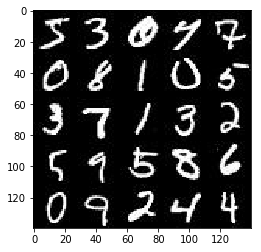

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

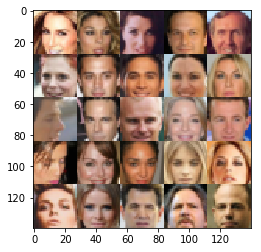

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\KevinRuan\AppData\Local\conda\conda\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input layer is 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 * 14 * 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 * 7 * 128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7 * 7 * 128))
        logits = tf.layers.dense(flat, 1)
        out =tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1,7,7,128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 * 7 * 128
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14 * 14 * 64
              
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28 * 28 * out_channel_dim
        
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
 
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                   labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model     
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    if data_image_mode == "RGB":
        out_channel_dim = 3
    else:
        out_channel_dim = 1  
        
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images,
                                                     input_z:batch_z,
                                                    input_learning_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real:batch_images,
                                                     input_z:batch_z,
                                                    input_learning_rate:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z,input_real:batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                            "Step: {}...".format(steps),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d),
                            "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, out_channel_dim, data_image_mode)
                    
                
                
                
                
                
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0/2... Step: 10... Discriminator Loss: 0.5159... Generator Loss: 3.1370
Epoch 0/2... Step: 20... Discriminator Loss: 1.2306... Generator Loss: 1.0361
Epoch 0/2... Step: 30... Discriminator Loss: 0.4711... Generator Loss: 4.1998
Epoch 0/2... Step: 40... Discriminator Loss: 0.4142... Generator Loss: 6.6255
Epoch 0/2... Step: 50... Discriminator Loss: 0.3810... Generator Loss: 3.9571
Epoch 0/2... Step: 60... Discriminator Loss: 0.3663... Generator Loss: 4.1163
Epoch 0/2... Step: 70... Discriminator Loss: 0.6190... Generator Loss: 3.9115
Epoch 0/2... Step: 80... Discriminator Loss: 0.4923... Generator Loss: 4.4656
Epoch 0/2... Step: 90... Discriminator Loss: 0.4096... Generator Loss: 5.0510
Epoch 0/2... Step: 100... Discriminator Loss: 0.3749... Generator Loss: 8.1058


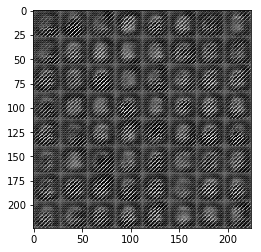

Epoch 0/2... Step: 110... Discriminator Loss: 0.4731... Generator Loss: 4.4485
Epoch 0/2... Step: 120... Discriminator Loss: 0.4425... Generator Loss: 8.3061
Epoch 0/2... Step: 130... Discriminator Loss: 0.4645... Generator Loss: 5.1886
Epoch 0/2... Step: 140... Discriminator Loss: 0.4175... Generator Loss: 4.6458
Epoch 0/2... Step: 150... Discriminator Loss: 0.3831... Generator Loss: 4.9779
Epoch 0/2... Step: 160... Discriminator Loss: 0.3750... Generator Loss: 6.0568
Epoch 0/2... Step: 170... Discriminator Loss: 0.4192... Generator Loss: 8.6592
Epoch 0/2... Step: 180... Discriminator Loss: 0.3752... Generator Loss: 5.4908
Epoch 0/2... Step: 190... Discriminator Loss: 0.3789... Generator Loss: 4.0504
Epoch 0/2... Step: 200... Discriminator Loss: 0.3911... Generator Loss: 4.1423


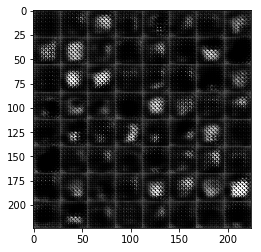

Epoch 0/2... Step: 210... Discriminator Loss: 0.4249... Generator Loss: 3.3084
Epoch 0/2... Step: 220... Discriminator Loss: 0.3757... Generator Loss: 4.2036
Epoch 0/2... Step: 230... Discriminator Loss: 0.6177... Generator Loss: 2.1013
Epoch 0/2... Step: 240... Discriminator Loss: 0.3691... Generator Loss: 6.1114
Epoch 0/2... Step: 250... Discriminator Loss: 0.3594... Generator Loss: 5.4256
Epoch 0/2... Step: 260... Discriminator Loss: 0.3795... Generator Loss: 6.2653
Epoch 0/2... Step: 270... Discriminator Loss: 0.3573... Generator Loss: 5.8045
Epoch 0/2... Step: 280... Discriminator Loss: 0.3462... Generator Loss: 6.8060
Epoch 0/2... Step: 290... Discriminator Loss: 0.3727... Generator Loss: 4.7611
Epoch 0/2... Step: 300... Discriminator Loss: 0.4034... Generator Loss: 6.7718


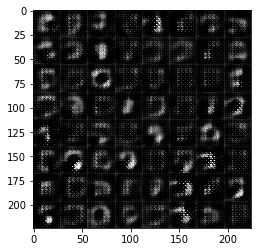

Epoch 0/2... Step: 310... Discriminator Loss: 0.3739... Generator Loss: 3.9235
Epoch 0/2... Step: 320... Discriminator Loss: 0.3731... Generator Loss: 3.9011
Epoch 0/2... Step: 330... Discriminator Loss: 0.3432... Generator Loss: 6.9751
Epoch 0/2... Step: 340... Discriminator Loss: 0.3595... Generator Loss: 8.7366
Epoch 0/2... Step: 350... Discriminator Loss: 0.3625... Generator Loss: 6.9960
Epoch 0/2... Step: 360... Discriminator Loss: 0.3424... Generator Loss: 7.0691
Epoch 0/2... Step: 370... Discriminator Loss: 0.3348... Generator Loss: 6.3725
Epoch 0/2... Step: 380... Discriminator Loss: 0.3387... Generator Loss: 5.8951
Epoch 0/2... Step: 390... Discriminator Loss: 0.3396... Generator Loss: 4.9798
Epoch 0/2... Step: 400... Discriminator Loss: 0.3360... Generator Loss: 5.9095


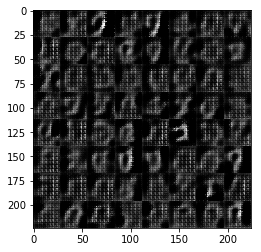

Epoch 0/2... Step: 410... Discriminator Loss: 0.3540... Generator Loss: 4.2041
Epoch 0/2... Step: 420... Discriminator Loss: 0.3429... Generator Loss: 5.8478
Epoch 0/2... Step: 430... Discriminator Loss: 0.3447... Generator Loss: 5.2078
Epoch 0/2... Step: 440... Discriminator Loss: 0.3382... Generator Loss: 5.3886
Epoch 0/2... Step: 450... Discriminator Loss: 0.3393... Generator Loss: 5.8884
Epoch 0/2... Step: 460... Discriminator Loss: 0.3433... Generator Loss: 5.2034
Epoch 0/2... Step: 470... Discriminator Loss: 0.3328... Generator Loss: 5.9796
Epoch 0/2... Step: 480... Discriminator Loss: 0.4195... Generator Loss: 3.4333
Epoch 0/2... Step: 490... Discriminator Loss: 0.3576... Generator Loss: 5.7401
Epoch 0/2... Step: 500... Discriminator Loss: 0.3826... Generator Loss: 3.9403


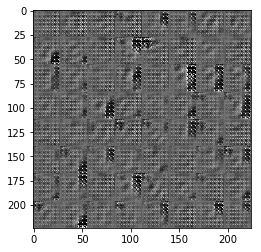

Epoch 0/2... Step: 510... Discriminator Loss: 0.3711... Generator Loss: 4.0248
Epoch 0/2... Step: 520... Discriminator Loss: 0.3790... Generator Loss: 4.2376
Epoch 0/2... Step: 530... Discriminator Loss: 0.3869... Generator Loss: 5.1307
Epoch 0/2... Step: 540... Discriminator Loss: 0.4127... Generator Loss: 3.8463
Epoch 0/2... Step: 550... Discriminator Loss: 0.4083... Generator Loss: 3.6739
Epoch 0/2... Step: 560... Discriminator Loss: 0.4455... Generator Loss: 4.5208
Epoch 0/2... Step: 570... Discriminator Loss: 0.3733... Generator Loss: 5.4491
Epoch 0/2... Step: 580... Discriminator Loss: 0.3964... Generator Loss: 4.5970
Epoch 0/2... Step: 590... Discriminator Loss: 0.4072... Generator Loss: 3.6923
Epoch 0/2... Step: 600... Discriminator Loss: 0.3583... Generator Loss: 5.2849


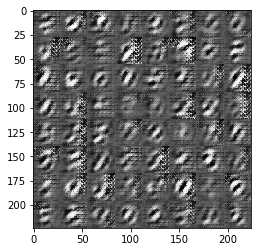

Epoch 0/2... Step: 610... Discriminator Loss: 0.3831... Generator Loss: 4.5290
Epoch 0/2... Step: 620... Discriminator Loss: 0.4945... Generator Loss: 3.0429
Epoch 0/2... Step: 630... Discriminator Loss: 0.3906... Generator Loss: 6.3731
Epoch 0/2... Step: 640... Discriminator Loss: 0.4732... Generator Loss: 3.5288
Epoch 0/2... Step: 650... Discriminator Loss: 0.3841... Generator Loss: 5.5720
Epoch 0/2... Step: 660... Discriminator Loss: 0.3719... Generator Loss: 4.6463
Epoch 0/2... Step: 670... Discriminator Loss: 0.3628... Generator Loss: 5.1689
Epoch 0/2... Step: 680... Discriminator Loss: 0.4617... Generator Loss: 2.7890
Epoch 0/2... Step: 690... Discriminator Loss: 0.3742... Generator Loss: 5.9183
Epoch 0/2... Step: 700... Discriminator Loss: 0.3788... Generator Loss: 4.9880


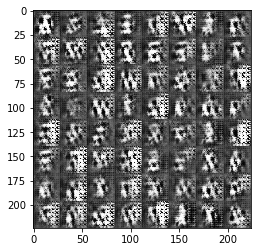

Epoch 0/2... Step: 710... Discriminator Loss: 0.4051... Generator Loss: 3.5155
Epoch 0/2... Step: 720... Discriminator Loss: 0.3792... Generator Loss: 5.3547
Epoch 0/2... Step: 730... Discriminator Loss: 0.3611... Generator Loss: 5.6436
Epoch 0/2... Step: 740... Discriminator Loss: 0.3993... Generator Loss: 4.2638
Epoch 0/2... Step: 750... Discriminator Loss: 0.3614... Generator Loss: 4.9521
Epoch 0/2... Step: 760... Discriminator Loss: 0.3685... Generator Loss: 4.4460
Epoch 0/2... Step: 770... Discriminator Loss: 0.4321... Generator Loss: 4.2160
Epoch 0/2... Step: 780... Discriminator Loss: 0.4214... Generator Loss: 3.3653
Epoch 0/2... Step: 790... Discriminator Loss: 0.3848... Generator Loss: 4.1271
Epoch 0/2... Step: 800... Discriminator Loss: 0.6454... Generator Loss: 4.1352


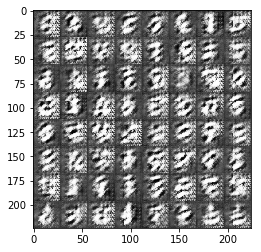

Epoch 0/2... Step: 810... Discriminator Loss: 0.4145... Generator Loss: 4.7219
Epoch 0/2... Step: 820... Discriminator Loss: 0.4782... Generator Loss: 6.9036
Epoch 0/2... Step: 830... Discriminator Loss: 0.4249... Generator Loss: 4.8478
Epoch 0/2... Step: 840... Discriminator Loss: 0.5777... Generator Loss: 2.7102
Epoch 0/2... Step: 850... Discriminator Loss: 0.4464... Generator Loss: 6.7829
Epoch 0/2... Step: 860... Discriminator Loss: 1.2277... Generator Loss: 11.9571
Epoch 0/2... Step: 870... Discriminator Loss: 0.6527... Generator Loss: 2.8990
Epoch 0/2... Step: 880... Discriminator Loss: 0.4218... Generator Loss: 6.3606
Epoch 0/2... Step: 890... Discriminator Loss: 0.4459... Generator Loss: 4.3112
Epoch 0/2... Step: 900... Discriminator Loss: 0.4290... Generator Loss: 5.2914


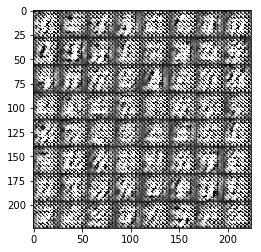

Epoch 0/2... Step: 910... Discriminator Loss: 0.3606... Generator Loss: 5.1541
Epoch 0/2... Step: 920... Discriminator Loss: 0.4135... Generator Loss: 4.5968
Epoch 0/2... Step: 930... Discriminator Loss: 0.3671... Generator Loss: 5.7205
Epoch 1/2... Step: 940... Discriminator Loss: 0.5789... Generator Loss: 4.9783
Epoch 1/2... Step: 950... Discriminator Loss: 0.3744... Generator Loss: 4.8696
Epoch 1/2... Step: 960... Discriminator Loss: 0.4647... Generator Loss: 4.2249
Epoch 1/2... Step: 970... Discriminator Loss: 0.4444... Generator Loss: 4.1652
Epoch 1/2... Step: 980... Discriminator Loss: 0.4351... Generator Loss: 4.1999
Epoch 1/2... Step: 990... Discriminator Loss: 0.4189... Generator Loss: 3.7672
Epoch 1/2... Step: 1000... Discriminator Loss: 0.4139... Generator Loss: 3.5599


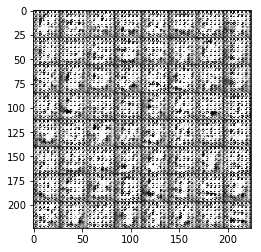

Epoch 1/2... Step: 1010... Discriminator Loss: 0.3825... Generator Loss: 4.6028
Epoch 1/2... Step: 1020... Discriminator Loss: 0.4327... Generator Loss: 3.1813
Epoch 1/2... Step: 1030... Discriminator Loss: 0.4140... Generator Loss: 3.3597
Epoch 1/2... Step: 1040... Discriminator Loss: 0.4430... Generator Loss: 2.9094
Epoch 1/2... Step: 1050... Discriminator Loss: 0.4008... Generator Loss: 4.1091
Epoch 1/2... Step: 1060... Discriminator Loss: 0.3815... Generator Loss: 3.9513
Epoch 1/2... Step: 1070... Discriminator Loss: 0.4040... Generator Loss: 3.5669
Epoch 1/2... Step: 1080... Discriminator Loss: 0.3915... Generator Loss: 4.0985
Epoch 1/2... Step: 1090... Discriminator Loss: 0.3770... Generator Loss: 4.0433
Epoch 1/2... Step: 1100... Discriminator Loss: 0.3919... Generator Loss: 4.2455


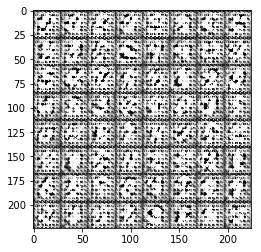

Epoch 1/2... Step: 1110... Discriminator Loss: 0.3743... Generator Loss: 3.9992
Epoch 1/2... Step: 1120... Discriminator Loss: 0.4037... Generator Loss: 3.8247
Epoch 1/2... Step: 1130... Discriminator Loss: 0.3981... Generator Loss: 3.7856
Epoch 1/2... Step: 1140... Discriminator Loss: 0.3909... Generator Loss: 5.8751
Epoch 1/2... Step: 1150... Discriminator Loss: 0.7352... Generator Loss: 1.9399
Epoch 1/2... Step: 1160... Discriminator Loss: 0.5797... Generator Loss: 2.2503
Epoch 1/2... Step: 1170... Discriminator Loss: 0.5143... Generator Loss: 5.0035
Epoch 1/2... Step: 1180... Discriminator Loss: 0.4335... Generator Loss: 4.3521
Epoch 1/2... Step: 1190... Discriminator Loss: 0.4325... Generator Loss: 3.5422
Epoch 1/2... Step: 1200... Discriminator Loss: 0.3880... Generator Loss: 3.7831


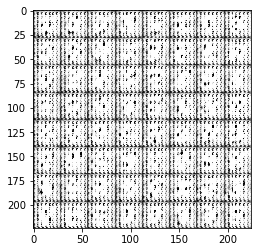

Epoch 1/2... Step: 1210... Discriminator Loss: 0.4245... Generator Loss: 3.0041
Epoch 1/2... Step: 1220... Discriminator Loss: 0.5721... Generator Loss: 2.6756
Epoch 1/2... Step: 1230... Discriminator Loss: 0.3772... Generator Loss: 6.2423
Epoch 1/2... Step: 1240... Discriminator Loss: 0.5409... Generator Loss: 3.9454
Epoch 1/2... Step: 1250... Discriminator Loss: 0.4467... Generator Loss: 3.0700
Epoch 1/2... Step: 1260... Discriminator Loss: 0.4507... Generator Loss: 7.2125
Epoch 1/2... Step: 1270... Discriminator Loss: 0.5702... Generator Loss: 2.3975
Epoch 1/2... Step: 1280... Discriminator Loss: 0.4455... Generator Loss: 3.2703
Epoch 1/2... Step: 1290... Discriminator Loss: 0.3696... Generator Loss: 5.1756
Epoch 1/2... Step: 1300... Discriminator Loss: 0.4801... Generator Loss: 2.9295


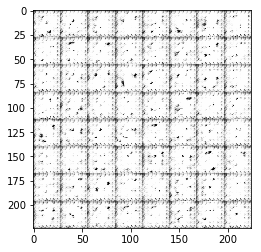

Epoch 1/2... Step: 1310... Discriminator Loss: 0.3774... Generator Loss: 5.0991
Epoch 1/2... Step: 1320... Discriminator Loss: 0.6081... Generator Loss: 2.1571
Epoch 1/2... Step: 1330... Discriminator Loss: 0.3546... Generator Loss: 6.1949
Epoch 1/2... Step: 1340... Discriminator Loss: 0.4413... Generator Loss: 2.7808
Epoch 1/2... Step: 1350... Discriminator Loss: 0.5277... Generator Loss: 5.7833
Epoch 1/2... Step: 1360... Discriminator Loss: 0.3784... Generator Loss: 4.1222
Epoch 1/2... Step: 1370... Discriminator Loss: 0.3779... Generator Loss: 3.6988
Epoch 1/2... Step: 1380... Discriminator Loss: 0.3832... Generator Loss: 4.2574
Epoch 1/2... Step: 1390... Discriminator Loss: 0.4223... Generator Loss: 3.1704
Epoch 1/2... Step: 1400... Discriminator Loss: 0.4456... Generator Loss: 3.0827


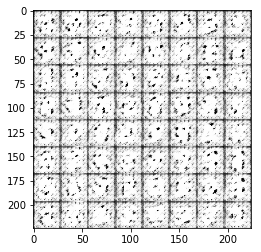

Epoch 1/2... Step: 1410... Discriminator Loss: 0.3978... Generator Loss: 3.3134
Epoch 1/2... Step: 1420... Discriminator Loss: 0.4000... Generator Loss: 4.1649
Epoch 1/2... Step: 1430... Discriminator Loss: 0.3767... Generator Loss: 3.7952
Epoch 1/2... Step: 1440... Discriminator Loss: 0.3691... Generator Loss: 4.2048
Epoch 1/2... Step: 1450... Discriminator Loss: 0.3947... Generator Loss: 3.7784
Epoch 1/2... Step: 1460... Discriminator Loss: 0.3893... Generator Loss: 3.8015
Epoch 1/2... Step: 1470... Discriminator Loss: 0.3838... Generator Loss: 4.5686
Epoch 1/2... Step: 1480... Discriminator Loss: 0.3655... Generator Loss: 4.2752
Epoch 1/2... Step: 1490... Discriminator Loss: 0.4077... Generator Loss: 3.3544
Epoch 1/2... Step: 1500... Discriminator Loss: 0.3974... Generator Loss: 4.4897


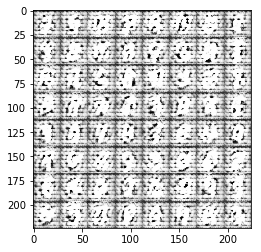

Epoch 1/2... Step: 1510... Discriminator Loss: 0.3890... Generator Loss: 5.2482
Epoch 1/2... Step: 1520... Discriminator Loss: 0.3815... Generator Loss: 4.4447
Epoch 1/2... Step: 1530... Discriminator Loss: 0.3897... Generator Loss: 3.9736
Epoch 1/2... Step: 1540... Discriminator Loss: 0.3687... Generator Loss: 4.5444
Epoch 1/2... Step: 1550... Discriminator Loss: 0.3997... Generator Loss: 4.6891
Epoch 1/2... Step: 1560... Discriminator Loss: 0.4372... Generator Loss: 3.1043
Epoch 1/2... Step: 1570... Discriminator Loss: 0.3693... Generator Loss: 4.0837
Epoch 1/2... Step: 1580... Discriminator Loss: 0.3752... Generator Loss: 4.5373
Epoch 1/2... Step: 1590... Discriminator Loss: 0.3910... Generator Loss: 4.0166
Epoch 1/2... Step: 1600... Discriminator Loss: 0.4600... Generator Loss: 2.9066


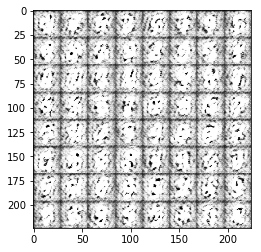

Epoch 1/2... Step: 1610... Discriminator Loss: 0.3814... Generator Loss: 4.9125
Epoch 1/2... Step: 1620... Discriminator Loss: 0.3686... Generator Loss: 5.0316
Epoch 1/2... Step: 1630... Discriminator Loss: 0.3631... Generator Loss: 4.6287
Epoch 1/2... Step: 1640... Discriminator Loss: 0.4176... Generator Loss: 3.5889
Epoch 1/2... Step: 1650... Discriminator Loss: 0.3732... Generator Loss: 5.6644
Epoch 1/2... Step: 1660... Discriminator Loss: 0.3663... Generator Loss: 4.4774
Epoch 1/2... Step: 1670... Discriminator Loss: 0.3711... Generator Loss: 4.1430
Epoch 1/2... Step: 1680... Discriminator Loss: 0.3666... Generator Loss: 4.5643
Epoch 1/2... Step: 1690... Discriminator Loss: 0.3786... Generator Loss: 4.9299
Epoch 1/2... Step: 1700... Discriminator Loss: 0.3563... Generator Loss: 4.8951


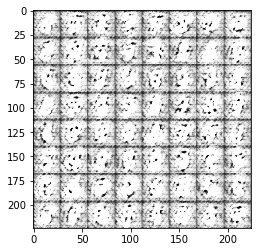

Epoch 1/2... Step: 1710... Discriminator Loss: 0.3605... Generator Loss: 4.2975
Epoch 1/2... Step: 1720... Discriminator Loss: 0.3660... Generator Loss: 4.2211
Epoch 1/2... Step: 1730... Discriminator Loss: 0.3435... Generator Loss: 5.8799
Epoch 1/2... Step: 1740... Discriminator Loss: 0.3541... Generator Loss: 5.0701
Epoch 1/2... Step: 1750... Discriminator Loss: 0.3467... Generator Loss: 5.1287
Epoch 1/2... Step: 1760... Discriminator Loss: 0.4287... Generator Loss: 3.7775
Epoch 1/2... Step: 1770... Discriminator Loss: 0.4078... Generator Loss: 3.6010
Epoch 1/2... Step: 1780... Discriminator Loss: 1.3384... Generator Loss: 1.1049
Epoch 1/2... Step: 1790... Discriminator Loss: 0.5444... Generator Loss: 3.2706
Epoch 1/2... Step: 1800... Discriminator Loss: 0.6291... Generator Loss: 5.8262


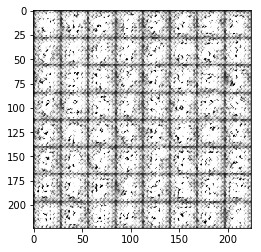

Epoch 1/2... Step: 1810... Discriminator Loss: 0.6093... Generator Loss: 5.5540
Epoch 1/2... Step: 1820... Discriminator Loss: 0.4843... Generator Loss: 4.8578
Epoch 1/2... Step: 1830... Discriminator Loss: 0.6652... Generator Loss: 2.3625
Epoch 1/2... Step: 1840... Discriminator Loss: 0.5742... Generator Loss: 2.6839
Epoch 1/2... Step: 1850... Discriminator Loss: 0.4025... Generator Loss: 5.4149
Epoch 1/2... Step: 1860... Discriminator Loss: 0.4109... Generator Loss: 6.9452
Epoch 1/2... Step: 1870... Discriminator Loss: 0.7172... Generator Loss: 2.4118


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0/1... Step: 10... Discriminator Loss: 0.6290... Generator Loss: 3.5186
Epoch 0/1... Step: 20... Discriminator Loss: 0.4443... Generator Loss: 4.9624
Epoch 0/1... Step: 30... Discriminator Loss: 0.4916... Generator Loss: 5.6958
Epoch 0/1... Step: 40... Discriminator Loss: 0.4392... Generator Loss: 4.0752
Epoch 0/1... Step: 50... Discriminator Loss: 0.4927... Generator Loss: 3.1108
Epoch 0/1... Step: 60... Discriminator Loss: 0.3626... Generator Loss: 8.0958
Epoch 0/1... Step: 70... Discriminator Loss: 0.4018... Generator Loss: 9.2558
Epoch 0/1... Step: 80... Discriminator Loss: 0.4102... Generator Loss: 4.5842
Epoch 0/1... Step: 90... Discriminator Loss: 0.3476... Generator Loss: 6.7465
Epoch 0/1... Step: 100... Discriminator Loss: 0.3474... Generator Loss: 6.7756


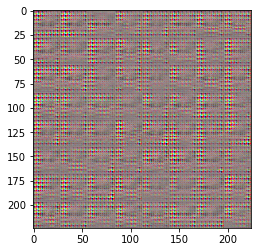

Epoch 0/1... Step: 110... Discriminator Loss: 0.3380... Generator Loss: 6.2446
Epoch 0/1... Step: 120... Discriminator Loss: 0.3350... Generator Loss: 6.1235
Epoch 0/1... Step: 130... Discriminator Loss: 0.3357... Generator Loss: 5.9439
Epoch 0/1... Step: 140... Discriminator Loss: 0.3402... Generator Loss: 5.8224
Epoch 0/1... Step: 150... Discriminator Loss: 0.3372... Generator Loss: 5.8560
Epoch 0/1... Step: 160... Discriminator Loss: 0.3353... Generator Loss: 5.9540
Epoch 0/1... Step: 170... Discriminator Loss: 0.3356... Generator Loss: 7.3475
Epoch 0/1... Step: 180... Discriminator Loss: 0.3335... Generator Loss: 6.0109
Epoch 0/1... Step: 190... Discriminator Loss: 0.3390... Generator Loss: 6.1775
Epoch 0/1... Step: 200... Discriminator Loss: 0.3316... Generator Loss: 6.3032


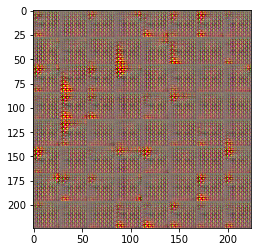

Epoch 0/1... Step: 210... Discriminator Loss: 0.3301... Generator Loss: 7.6834
Epoch 0/1... Step: 220... Discriminator Loss: 0.3305... Generator Loss: 6.5152
Epoch 0/1... Step: 230... Discriminator Loss: 0.3331... Generator Loss: 6.3837
Epoch 0/1... Step: 240... Discriminator Loss: 0.3348... Generator Loss: 6.4441
Epoch 0/1... Step: 250... Discriminator Loss: 0.3293... Generator Loss: 6.6367
Epoch 0/1... Step: 260... Discriminator Loss: 0.3292... Generator Loss: 7.0294
Epoch 0/1... Step: 270... Discriminator Loss: 0.3407... Generator Loss: 6.6016
Epoch 0/1... Step: 280... Discriminator Loss: 0.3303... Generator Loss: 6.8873
Epoch 0/1... Step: 290... Discriminator Loss: 0.3418... Generator Loss: 4.9266
Epoch 0/1... Step: 300... Discriminator Loss: 0.3372... Generator Loss: 5.1052


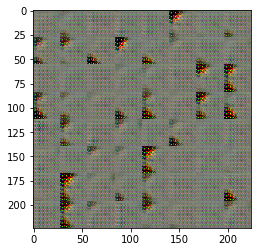

Epoch 0/1... Step: 310... Discriminator Loss: 0.3531... Generator Loss: 4.0356
Epoch 0/1... Step: 320... Discriminator Loss: 0.3530... Generator Loss: 5.0262
Epoch 0/1... Step: 330... Discriminator Loss: 0.3925... Generator Loss: 6.2573
Epoch 0/1... Step: 340... Discriminator Loss: 0.3886... Generator Loss: 3.8136
Epoch 0/1... Step: 350... Discriminator Loss: 0.3975... Generator Loss: 4.5605
Epoch 0/1... Step: 360... Discriminator Loss: 0.3712... Generator Loss: 4.6454
Epoch 0/1... Step: 370... Discriminator Loss: 0.5850... Generator Loss: 6.1225
Epoch 0/1... Step: 380... Discriminator Loss: 0.4528... Generator Loss: 2.7490
Epoch 0/1... Step: 390... Discriminator Loss: 0.4326... Generator Loss: 5.2788
Epoch 0/1... Step: 400... Discriminator Loss: 0.3573... Generator Loss: 4.9906


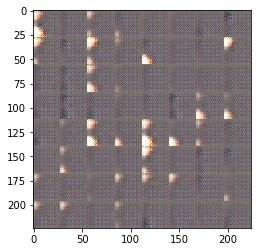

Epoch 0/1... Step: 410... Discriminator Loss: 0.3641... Generator Loss: 4.7828
Epoch 0/1... Step: 420... Discriminator Loss: 0.3555... Generator Loss: 5.6414
Epoch 0/1... Step: 430... Discriminator Loss: 0.3609... Generator Loss: 4.0104
Epoch 0/1... Step: 440... Discriminator Loss: 0.3825... Generator Loss: 4.4399
Epoch 0/1... Step: 450... Discriminator Loss: 0.3656... Generator Loss: 6.0652
Epoch 0/1... Step: 460... Discriminator Loss: 0.3829... Generator Loss: 7.5981
Epoch 0/1... Step: 470... Discriminator Loss: 0.3962... Generator Loss: 8.9498
Epoch 0/1... Step: 480... Discriminator Loss: 0.4180... Generator Loss: 6.3390
Epoch 0/1... Step: 490... Discriminator Loss: 1.2510... Generator Loss: 8.9369
Epoch 0/1... Step: 500... Discriminator Loss: 0.5716... Generator Loss: 5.7948


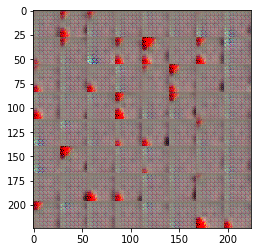

Epoch 0/1... Step: 510... Discriminator Loss: 0.3866... Generator Loss: 9.7044
Epoch 0/1... Step: 520... Discriminator Loss: 0.4621... Generator Loss: 4.0974
Epoch 0/1... Step: 530... Discriminator Loss: 0.3838... Generator Loss: 6.1904
Epoch 0/1... Step: 540... Discriminator Loss: 0.3577... Generator Loss: 5.3242
Epoch 0/1... Step: 550... Discriminator Loss: 0.4018... Generator Loss: 5.0337
Epoch 0/1... Step: 560... Discriminator Loss: 0.3722... Generator Loss: 4.2790
Epoch 0/1... Step: 570... Discriminator Loss: 0.3587... Generator Loss: 6.2695
Epoch 0/1... Step: 580... Discriminator Loss: 0.3458... Generator Loss: 5.7528
Epoch 0/1... Step: 590... Discriminator Loss: 0.3584... Generator Loss: 5.1049
Epoch 0/1... Step: 600... Discriminator Loss: 0.3829... Generator Loss: 4.2680


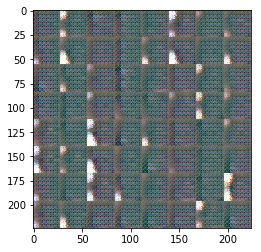

Epoch 0/1... Step: 610... Discriminator Loss: 0.3519... Generator Loss: 5.5365
Epoch 0/1... Step: 620... Discriminator Loss: 0.4093... Generator Loss: 5.6408
Epoch 0/1... Step: 630... Discriminator Loss: 0.3472... Generator Loss: 6.8842
Epoch 0/1... Step: 640... Discriminator Loss: 0.4251... Generator Loss: 3.0463
Epoch 0/1... Step: 650... Discriminator Loss: 0.4704... Generator Loss: 4.3650
Epoch 0/1... Step: 660... Discriminator Loss: 0.3780... Generator Loss: 4.7699
Epoch 0/1... Step: 670... Discriminator Loss: 0.4665... Generator Loss: 2.9579
Epoch 0/1... Step: 680... Discriminator Loss: 0.4455... Generator Loss: 3.1458
Epoch 0/1... Step: 690... Discriminator Loss: 0.4587... Generator Loss: 4.4213
Epoch 0/1... Step: 700... Discriminator Loss: 0.3911... Generator Loss: 4.1435


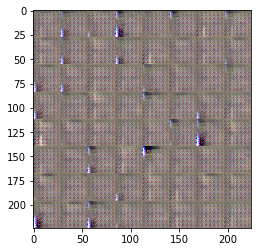

Epoch 0/1... Step: 710... Discriminator Loss: 0.4484... Generator Loss: 3.2897
Epoch 0/1... Step: 720... Discriminator Loss: 0.5558... Generator Loss: 3.6609
Epoch 0/1... Step: 730... Discriminator Loss: 0.4201... Generator Loss: 5.7830
Epoch 0/1... Step: 740... Discriminator Loss: 0.4235... Generator Loss: 4.3339
Epoch 0/1... Step: 750... Discriminator Loss: 0.5288... Generator Loss: 3.0579
Epoch 0/1... Step: 760... Discriminator Loss: 0.4150... Generator Loss: 4.9271
Epoch 0/1... Step: 770... Discriminator Loss: 0.4472... Generator Loss: 4.6279
Epoch 0/1... Step: 780... Discriminator Loss: 0.4486... Generator Loss: 5.4390
Epoch 0/1... Step: 790... Discriminator Loss: 0.3992... Generator Loss: 4.9056
Epoch 0/1... Step: 800... Discriminator Loss: 0.3916... Generator Loss: 4.7298


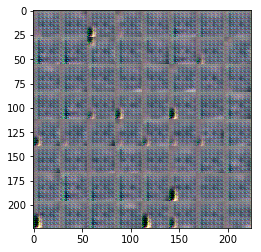

Epoch 0/1... Step: 810... Discriminator Loss: 0.3959... Generator Loss: 4.8058
Epoch 0/1... Step: 820... Discriminator Loss: 0.4533... Generator Loss: 3.5968
Epoch 0/1... Step: 830... Discriminator Loss: 0.3915... Generator Loss: 4.6007
Epoch 0/1... Step: 840... Discriminator Loss: 0.5473... Generator Loss: 2.1007
Epoch 0/1... Step: 850... Discriminator Loss: 0.6034... Generator Loss: 3.5313
Epoch 0/1... Step: 860... Discriminator Loss: 0.5693... Generator Loss: 6.1110
Epoch 0/1... Step: 870... Discriminator Loss: 0.6656... Generator Loss: 3.3744
Epoch 0/1... Step: 880... Discriminator Loss: 0.6908... Generator Loss: 2.2228
Epoch 0/1... Step: 890... Discriminator Loss: 0.5592... Generator Loss: 6.3673
Epoch 0/1... Step: 900... Discriminator Loss: 0.4778... Generator Loss: 5.4392


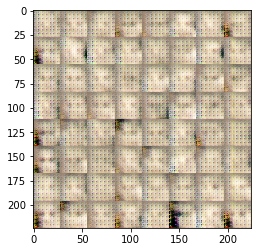

Epoch 0/1... Step: 910... Discriminator Loss: 0.4399... Generator Loss: 6.7783
Epoch 0/1... Step: 920... Discriminator Loss: 0.5228... Generator Loss: 2.8633
Epoch 0/1... Step: 930... Discriminator Loss: 0.6105... Generator Loss: 4.3999
Epoch 0/1... Step: 940... Discriminator Loss: 0.4067... Generator Loss: 5.5447
Epoch 0/1... Step: 950... Discriminator Loss: 0.4964... Generator Loss: 4.5041
Epoch 0/1... Step: 960... Discriminator Loss: 0.4482... Generator Loss: 5.1328
Epoch 0/1... Step: 970... Discriminator Loss: 0.4320... Generator Loss: 3.6536
Epoch 0/1... Step: 980... Discriminator Loss: 0.4077... Generator Loss: 5.6542
Epoch 0/1... Step: 990... Discriminator Loss: 0.5466... Generator Loss: 3.5819
Epoch 0/1... Step: 1000... Discriminator Loss: 0.4998... Generator Loss: 2.5307


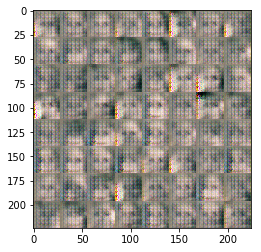

Epoch 0/1... Step: 1010... Discriminator Loss: 0.4257... Generator Loss: 4.3328
Epoch 0/1... Step: 1020... Discriminator Loss: 0.5796... Generator Loss: 2.1605
Epoch 0/1... Step: 1030... Discriminator Loss: 0.4869... Generator Loss: 2.8201
Epoch 0/1... Step: 1040... Discriminator Loss: 0.4014... Generator Loss: 4.6548
Epoch 0/1... Step: 1050... Discriminator Loss: 0.4681... Generator Loss: 6.6368
Epoch 0/1... Step: 1060... Discriminator Loss: 0.4756... Generator Loss: 3.8056
Epoch 0/1... Step: 1070... Discriminator Loss: 0.4469... Generator Loss: 5.5033
Epoch 0/1... Step: 1080... Discriminator Loss: 0.5389... Generator Loss: 3.1232
Epoch 0/1... Step: 1090... Discriminator Loss: 0.4800... Generator Loss: 3.6306
Epoch 0/1... Step: 1100... Discriminator Loss: 0.9615... Generator Loss: 1.9943


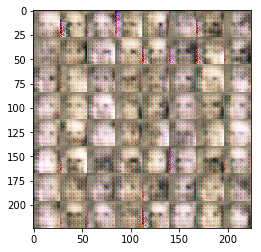

Epoch 0/1... Step: 1110... Discriminator Loss: 0.7295... Generator Loss: 2.2358
Epoch 0/1... Step: 1120... Discriminator Loss: 0.5765... Generator Loss: 3.0939
Epoch 0/1... Step: 1130... Discriminator Loss: 0.4731... Generator Loss: 3.9252
Epoch 0/1... Step: 1140... Discriminator Loss: 0.6200... Generator Loss: 4.4843
Epoch 0/1... Step: 1150... Discriminator Loss: 0.4832... Generator Loss: 4.1535
Epoch 0/1... Step: 1160... Discriminator Loss: 0.6863... Generator Loss: 5.1999
Epoch 0/1... Step: 1170... Discriminator Loss: 0.4868... Generator Loss: 3.5259
Epoch 0/1... Step: 1180... Discriminator Loss: 0.5025... Generator Loss: 3.4540
Epoch 0/1... Step: 1190... Discriminator Loss: 0.4277... Generator Loss: 4.6657
Epoch 0/1... Step: 1200... Discriminator Loss: 0.5202... Generator Loss: 3.2238


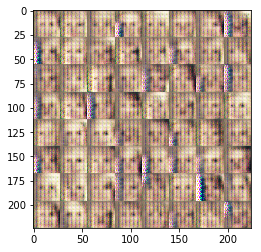

Epoch 0/1... Step: 1210... Discriminator Loss: 0.5222... Generator Loss: 4.6943
Epoch 0/1... Step: 1220... Discriminator Loss: 0.5043... Generator Loss: 4.6104
Epoch 0/1... Step: 1230... Discriminator Loss: 0.4198... Generator Loss: 4.9903
Epoch 0/1... Step: 1240... Discriminator Loss: 0.4249... Generator Loss: 5.0520
Epoch 0/1... Step: 1250... Discriminator Loss: 0.4271... Generator Loss: 4.0245
Epoch 0/1... Step: 1260... Discriminator Loss: 0.3895... Generator Loss: 4.4825
Epoch 0/1... Step: 1270... Discriminator Loss: 0.5346... Generator Loss: 3.0234
Epoch 0/1... Step: 1280... Discriminator Loss: 0.4818... Generator Loss: 3.8177
Epoch 0/1... Step: 1290... Discriminator Loss: 0.7133... Generator Loss: 2.1630
Epoch 0/1... Step: 1300... Discriminator Loss: 0.5717... Generator Loss: 3.3443


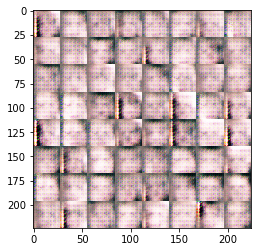

Epoch 0/1... Step: 1310... Discriminator Loss: 0.4734... Generator Loss: 5.3111
Epoch 0/1... Step: 1320... Discriminator Loss: 0.5072... Generator Loss: 2.5786
Epoch 0/1... Step: 1330... Discriminator Loss: 0.5235... Generator Loss: 2.8581
Epoch 0/1... Step: 1340... Discriminator Loss: 0.4135... Generator Loss: 4.6928
Epoch 0/1... Step: 1350... Discriminator Loss: 0.7158... Generator Loss: 2.2147
Epoch 0/1... Step: 1360... Discriminator Loss: 0.6586... Generator Loss: 3.5714
Epoch 0/1... Step: 1370... Discriminator Loss: 0.4837... Generator Loss: 3.6347
Epoch 0/1... Step: 1380... Discriminator Loss: 0.4815... Generator Loss: 3.3214
Epoch 0/1... Step: 1390... Discriminator Loss: 0.4348... Generator Loss: 4.2767
Epoch 0/1... Step: 1400... Discriminator Loss: 0.4258... Generator Loss: 4.8182


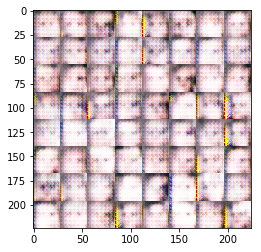

Epoch 0/1... Step: 1410... Discriminator Loss: 0.3983... Generator Loss: 4.0828
Epoch 0/1... Step: 1420... Discriminator Loss: 0.4287... Generator Loss: 3.9346
Epoch 0/1... Step: 1430... Discriminator Loss: 0.7919... Generator Loss: 2.1783
Epoch 0/1... Step: 1440... Discriminator Loss: 0.7112... Generator Loss: 4.0516
Epoch 0/1... Step: 1450... Discriminator Loss: 0.7769... Generator Loss: 2.4875
Epoch 0/1... Step: 1460... Discriminator Loss: 0.9509... Generator Loss: 10.3334
Epoch 0/1... Step: 1470... Discriminator Loss: 0.3947... Generator Loss: 5.3320
Epoch 0/1... Step: 1480... Discriminator Loss: 0.4181... Generator Loss: 3.9622
Epoch 0/1... Step: 1490... Discriminator Loss: 0.4201... Generator Loss: 4.0434
Epoch 0/1... Step: 1500... Discriminator Loss: 0.4014... Generator Loss: 4.3726


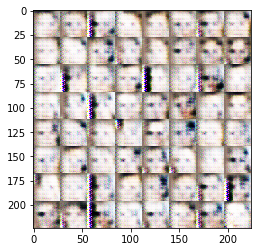

Epoch 0/1... Step: 1510... Discriminator Loss: 0.3796... Generator Loss: 4.3913
Epoch 0/1... Step: 1520... Discriminator Loss: 0.3689... Generator Loss: 5.1942
Epoch 0/1... Step: 1530... Discriminator Loss: 0.4123... Generator Loss: 3.2679
Epoch 0/1... Step: 1540... Discriminator Loss: 0.4354... Generator Loss: 4.9053
Epoch 0/1... Step: 1550... Discriminator Loss: 0.6841... Generator Loss: 6.7266
Epoch 0/1... Step: 1560... Discriminator Loss: 0.5112... Generator Loss: 3.4160
Epoch 0/1... Step: 1570... Discriminator Loss: 0.6324... Generator Loss: 6.3341
Epoch 0/1... Step: 1580... Discriminator Loss: 1.0122... Generator Loss: 3.5332
Epoch 0/1... Step: 1590... Discriminator Loss: 0.5271... Generator Loss: 2.6543
Epoch 0/1... Step: 1600... Discriminator Loss: 0.5649... Generator Loss: 2.8940


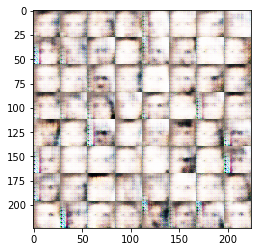

Epoch 0/1... Step: 1610... Discriminator Loss: 0.5265... Generator Loss: 2.4847
Epoch 0/1... Step: 1620... Discriminator Loss: 0.6893... Generator Loss: 1.8873
Epoch 0/1... Step: 1630... Discriminator Loss: 0.4649... Generator Loss: 3.1698
Epoch 0/1... Step: 1640... Discriminator Loss: 0.5980... Generator Loss: 2.1420
Epoch 0/1... Step: 1650... Discriminator Loss: 0.5301... Generator Loss: 3.2028
Epoch 0/1... Step: 1660... Discriminator Loss: 0.4490... Generator Loss: 4.1457
Epoch 0/1... Step: 1670... Discriminator Loss: 0.6964... Generator Loss: 3.8206
Epoch 0/1... Step: 1680... Discriminator Loss: 0.5939... Generator Loss: 2.3743
Epoch 0/1... Step: 1690... Discriminator Loss: 0.5387... Generator Loss: 3.0129
Epoch 0/1... Step: 1700... Discriminator Loss: 0.7859... Generator Loss: 4.8924


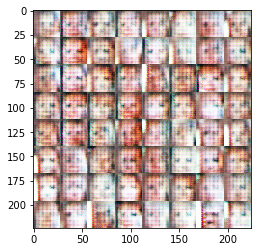

Epoch 0/1... Step: 1710... Discriminator Loss: 0.5650... Generator Loss: 2.5518
Epoch 0/1... Step: 1720... Discriminator Loss: 0.5792... Generator Loss: 3.2048
Epoch 0/1... Step: 1730... Discriminator Loss: 0.4118... Generator Loss: 5.2741
Epoch 0/1... Step: 1740... Discriminator Loss: 0.5221... Generator Loss: 5.5159
Epoch 0/1... Step: 1750... Discriminator Loss: 0.7526... Generator Loss: 4.3847
Epoch 0/1... Step: 1760... Discriminator Loss: 0.5938... Generator Loss: 3.4255
Epoch 0/1... Step: 1770... Discriminator Loss: 0.4400... Generator Loss: 4.9366
Epoch 0/1... Step: 1780... Discriminator Loss: 0.4542... Generator Loss: 4.4180
Epoch 0/1... Step: 1790... Discriminator Loss: 0.4947... Generator Loss: 3.0324
Epoch 0/1... Step: 1800... Discriminator Loss: 0.5878... Generator Loss: 2.7335


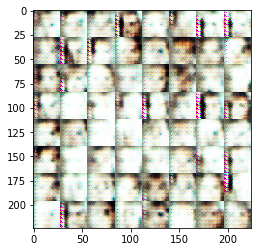

Epoch 0/1... Step: 1810... Discriminator Loss: 0.3800... Generator Loss: 4.8844
Epoch 0/1... Step: 1820... Discriminator Loss: 0.4731... Generator Loss: 3.5164
Epoch 0/1... Step: 1830... Discriminator Loss: 0.4725... Generator Loss: 2.7408
Epoch 0/1... Step: 1840... Discriminator Loss: 0.6887... Generator Loss: 1.9019
Epoch 0/1... Step: 1850... Discriminator Loss: 0.6742... Generator Loss: 2.9746
Epoch 0/1... Step: 1860... Discriminator Loss: 0.5067... Generator Loss: 4.9783
Epoch 0/1... Step: 1870... Discriminator Loss: 0.5552... Generator Loss: 3.2710
Epoch 0/1... Step: 1880... Discriminator Loss: 0.7237... Generator Loss: 3.8112
Epoch 0/1... Step: 1890... Discriminator Loss: 0.4764... Generator Loss: 4.2083
Epoch 0/1... Step: 1900... Discriminator Loss: 0.4704... Generator Loss: 4.6289


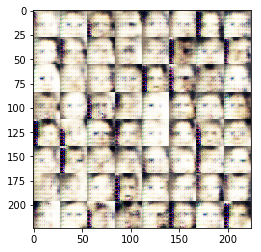

Epoch 0/1... Step: 1910... Discriminator Loss: 0.6535... Generator Loss: 2.5450
Epoch 0/1... Step: 1920... Discriminator Loss: 0.5577... Generator Loss: 2.6032
Epoch 0/1... Step: 1930... Discriminator Loss: 0.4191... Generator Loss: 4.4981
Epoch 0/1... Step: 1940... Discriminator Loss: 0.4667... Generator Loss: 3.1068
Epoch 0/1... Step: 1950... Discriminator Loss: 0.5257... Generator Loss: 3.2717
Epoch 0/1... Step: 1960... Discriminator Loss: 0.6365... Generator Loss: 1.9421
Epoch 0/1... Step: 1970... Discriminator Loss: 0.4805... Generator Loss: 4.0576
Epoch 0/1... Step: 1980... Discriminator Loss: 0.4882... Generator Loss: 3.9991
Epoch 0/1... Step: 1990... Discriminator Loss: 0.6328... Generator Loss: 2.6608
Epoch 0/1... Step: 2000... Discriminator Loss: 0.5363... Generator Loss: 2.7782


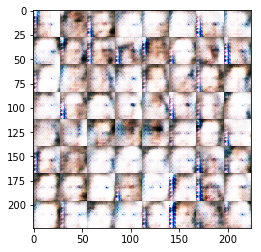

Epoch 0/1... Step: 2010... Discriminator Loss: 0.5502... Generator Loss: 3.0699
Epoch 0/1... Step: 2020... Discriminator Loss: 0.5034... Generator Loss: 2.8481
Epoch 0/1... Step: 2030... Discriminator Loss: 1.0077... Generator Loss: 2.2985
Epoch 0/1... Step: 2040... Discriminator Loss: 0.8938... Generator Loss: 2.4988
Epoch 0/1... Step: 2050... Discriminator Loss: 0.9040... Generator Loss: 6.9621
Epoch 0/1... Step: 2060... Discriminator Loss: 0.6725... Generator Loss: 2.4834
Epoch 0/1... Step: 2070... Discriminator Loss: 0.4806... Generator Loss: 4.0902
Epoch 0/1... Step: 2080... Discriminator Loss: 0.5184... Generator Loss: 4.0994
Epoch 0/1... Step: 2090... Discriminator Loss: 0.5031... Generator Loss: 2.6919
Epoch 0/1... Step: 2100... Discriminator Loss: 1.1922... Generator Loss: 1.4934


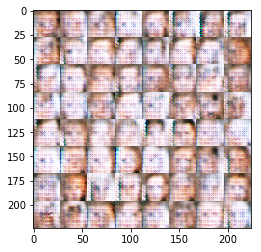

Epoch 0/1... Step: 2110... Discriminator Loss: 0.9637... Generator Loss: 2.1155
Epoch 0/1... Step: 2120... Discriminator Loss: 0.8964... Generator Loss: 1.6347
Epoch 0/1... Step: 2130... Discriminator Loss: 0.6632... Generator Loss: 3.5592
Epoch 0/1... Step: 2140... Discriminator Loss: 0.5566... Generator Loss: 3.6213
Epoch 0/1... Step: 2150... Discriminator Loss: 0.5559... Generator Loss: 2.7302
Epoch 0/1... Step: 2160... Discriminator Loss: 0.5673... Generator Loss: 2.9758
Epoch 0/1... Step: 2170... Discriminator Loss: 0.4562... Generator Loss: 5.3399
Epoch 0/1... Step: 2180... Discriminator Loss: 0.5072... Generator Loss: 3.8459
Epoch 0/1... Step: 2190... Discriminator Loss: 0.5261... Generator Loss: 4.1160
Epoch 0/1... Step: 2200... Discriminator Loss: 0.6533... Generator Loss: 4.7924


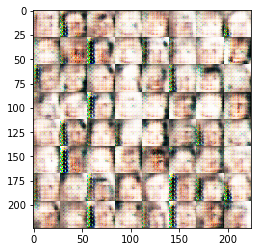

Epoch 0/1... Step: 2210... Discriminator Loss: 0.8070... Generator Loss: 1.7561
Epoch 0/1... Step: 2220... Discriminator Loss: 0.4482... Generator Loss: 3.5148
Epoch 0/1... Step: 2230... Discriminator Loss: 0.5077... Generator Loss: 3.0152
Epoch 0/1... Step: 2240... Discriminator Loss: 0.5416... Generator Loss: 3.9600
Epoch 0/1... Step: 2250... Discriminator Loss: 0.5362... Generator Loss: 3.0467
Epoch 0/1... Step: 2260... Discriminator Loss: 0.4408... Generator Loss: 3.0029
Epoch 0/1... Step: 2270... Discriminator Loss: 0.4157... Generator Loss: 3.9800
Epoch 0/1... Step: 2280... Discriminator Loss: 0.4585... Generator Loss: 4.4324
Epoch 0/1... Step: 2290... Discriminator Loss: 0.8123... Generator Loss: 3.6133
Epoch 0/1... Step: 2300... Discriminator Loss: 0.8660... Generator Loss: 1.4358


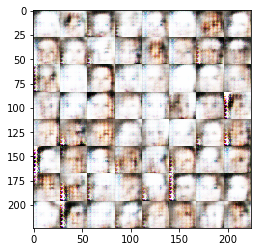

Epoch 0/1... Step: 2310... Discriminator Loss: 0.5216... Generator Loss: 3.2634
Epoch 0/1... Step: 2320... Discriminator Loss: 0.5477... Generator Loss: 3.5812
Epoch 0/1... Step: 2330... Discriminator Loss: 0.9007... Generator Loss: 1.8773
Epoch 0/1... Step: 2340... Discriminator Loss: 0.6184... Generator Loss: 3.4127
Epoch 0/1... Step: 2350... Discriminator Loss: 0.5195... Generator Loss: 3.0280
Epoch 0/1... Step: 2360... Discriminator Loss: 0.6047... Generator Loss: 3.3129
Epoch 0/1... Step: 2370... Discriminator Loss: 0.7098... Generator Loss: 2.6513
Epoch 0/1... Step: 2380... Discriminator Loss: 0.5188... Generator Loss: 3.5201
Epoch 0/1... Step: 2390... Discriminator Loss: 0.6406... Generator Loss: 1.9738
Epoch 0/1... Step: 2400... Discriminator Loss: 0.5621... Generator Loss: 3.6049


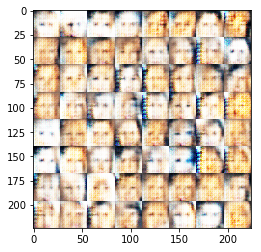

Epoch 0/1... Step: 2410... Discriminator Loss: 0.6264... Generator Loss: 2.1332
Epoch 0/1... Step: 2420... Discriminator Loss: 0.7989... Generator Loss: 1.7305
Epoch 0/1... Step: 2430... Discriminator Loss: 0.7069... Generator Loss: 2.5775
Epoch 0/1... Step: 2440... Discriminator Loss: 0.6439... Generator Loss: 4.8946
Epoch 0/1... Step: 2450... Discriminator Loss: 0.6884... Generator Loss: 3.1774
Epoch 0/1... Step: 2460... Discriminator Loss: 0.8324... Generator Loss: 3.7448
Epoch 0/1... Step: 2470... Discriminator Loss: 0.5150... Generator Loss: 5.2736
Epoch 0/1... Step: 2480... Discriminator Loss: 1.2331... Generator Loss: 1.3197
Epoch 0/1... Step: 2490... Discriminator Loss: 0.5222... Generator Loss: 4.8300
Epoch 0/1... Step: 2500... Discriminator Loss: 0.5832... Generator Loss: 2.8979


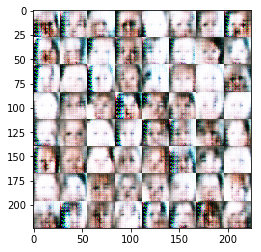

Epoch 0/1... Step: 2510... Discriminator Loss: 0.4159... Generator Loss: 4.4026
Epoch 0/1... Step: 2520... Discriminator Loss: 0.6776... Generator Loss: 2.7239
Epoch 0/1... Step: 2530... Discriminator Loss: 0.5304... Generator Loss: 3.6307
Epoch 0/1... Step: 2540... Discriminator Loss: 0.4395... Generator Loss: 4.9368
Epoch 0/1... Step: 2550... Discriminator Loss: 0.4760... Generator Loss: 4.4292
Epoch 0/1... Step: 2560... Discriminator Loss: 0.6406... Generator Loss: 3.2777
Epoch 0/1... Step: 2570... Discriminator Loss: 1.0079... Generator Loss: 1.8631
Epoch 0/1... Step: 2580... Discriminator Loss: 0.5730... Generator Loss: 3.3037
Epoch 0/1... Step: 2590... Discriminator Loss: 1.2036... Generator Loss: 2.3962
Epoch 0/1... Step: 2600... Discriminator Loss: 0.7446... Generator Loss: 3.6860


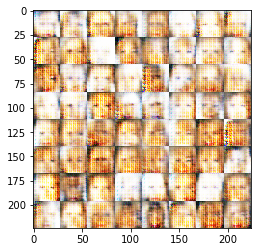

Epoch 0/1... Step: 2610... Discriminator Loss: 0.4700... Generator Loss: 5.7164
Epoch 0/1... Step: 2620... Discriminator Loss: 0.4246... Generator Loss: 6.0146
Epoch 0/1... Step: 2630... Discriminator Loss: 0.5883... Generator Loss: 4.3790
Epoch 0/1... Step: 2640... Discriminator Loss: 0.4726... Generator Loss: 3.7871
Epoch 0/1... Step: 2650... Discriminator Loss: 0.4981... Generator Loss: 4.0675
Epoch 0/1... Step: 2660... Discriminator Loss: 0.5013... Generator Loss: 5.0779
Epoch 0/1... Step: 2670... Discriminator Loss: 0.6180... Generator Loss: 3.3490
Epoch 0/1... Step: 2680... Discriminator Loss: 0.4468... Generator Loss: 5.3395
Epoch 0/1... Step: 2690... Discriminator Loss: 0.5718... Generator Loss: 2.1788
Epoch 0/1... Step: 2700... Discriminator Loss: 0.4786... Generator Loss: 5.9481


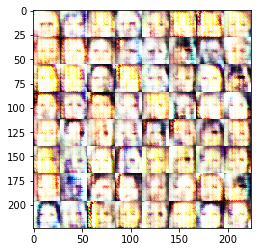

Epoch 0/1... Step: 2710... Discriminator Loss: 0.7825... Generator Loss: 6.1958
Epoch 0/1... Step: 2720... Discriminator Loss: 0.5215... Generator Loss: 5.6631
Epoch 0/1... Step: 2730... Discriminator Loss: 0.7454... Generator Loss: 4.1587
Epoch 0/1... Step: 2740... Discriminator Loss: 0.6278... Generator Loss: 3.7249
Epoch 0/1... Step: 2750... Discriminator Loss: 0.5076... Generator Loss: 3.9910
Epoch 0/1... Step: 2760... Discriminator Loss: 0.5004... Generator Loss: 3.1969
Epoch 0/1... Step: 2770... Discriminator Loss: 0.8060... Generator Loss: 2.9551
Epoch 0/1... Step: 2780... Discriminator Loss: 0.6534... Generator Loss: 3.6811
Epoch 0/1... Step: 2790... Discriminator Loss: 0.7293... Generator Loss: 1.6928
Epoch 0/1... Step: 2800... Discriminator Loss: 0.4704... Generator Loss: 3.5272


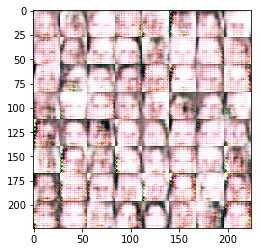

Epoch 0/1... Step: 2810... Discriminator Loss: 0.7122... Generator Loss: 2.5723
Epoch 0/1... Step: 2820... Discriminator Loss: 0.4949... Generator Loss: 6.5558
Epoch 0/1... Step: 2830... Discriminator Loss: 0.6841... Generator Loss: 2.9025
Epoch 0/1... Step: 2840... Discriminator Loss: 0.7013... Generator Loss: 3.4185
Epoch 0/1... Step: 2850... Discriminator Loss: 0.8474... Generator Loss: 1.5399
Epoch 0/1... Step: 2860... Discriminator Loss: 0.6050... Generator Loss: 3.4890
Epoch 0/1... Step: 2870... Discriminator Loss: 0.4608... Generator Loss: 4.1422
Epoch 0/1... Step: 2880... Discriminator Loss: 0.5914... Generator Loss: 3.1158
Epoch 0/1... Step: 2890... Discriminator Loss: 0.5468... Generator Loss: 2.4930
Epoch 0/1... Step: 2900... Discriminator Loss: 0.5015... Generator Loss: 3.3866


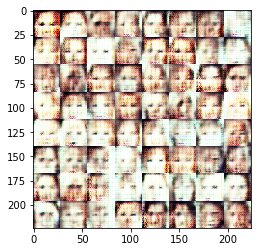

Epoch 0/1... Step: 2910... Discriminator Loss: 1.5638... Generator Loss: 5.2422
Epoch 0/1... Step: 2920... Discriminator Loss: 0.7646... Generator Loss: 2.3129
Epoch 0/1... Step: 2930... Discriminator Loss: 0.6733... Generator Loss: 2.0181
Epoch 0/1... Step: 2940... Discriminator Loss: 0.7217... Generator Loss: 1.7559
Epoch 0/1... Step: 2950... Discriminator Loss: 0.5831... Generator Loss: 4.1525
Epoch 0/1... Step: 2960... Discriminator Loss: 0.4773... Generator Loss: 3.5826
Epoch 0/1... Step: 2970... Discriminator Loss: 0.9330... Generator Loss: 2.4967
Epoch 0/1... Step: 2980... Discriminator Loss: 0.8274... Generator Loss: 3.8090
Epoch 0/1... Step: 2990... Discriminator Loss: 0.8815... Generator Loss: 1.4450
Epoch 0/1... Step: 3000... Discriminator Loss: 0.5701... Generator Loss: 2.8823


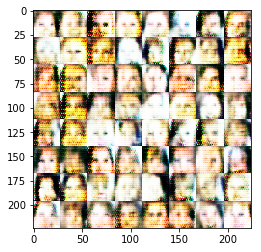

Epoch 0/1... Step: 3010... Discriminator Loss: 0.8648... Generator Loss: 1.7237
Epoch 0/1... Step: 3020... Discriminator Loss: 0.5299... Generator Loss: 4.7293
Epoch 0/1... Step: 3030... Discriminator Loss: 0.4471... Generator Loss: 4.0797
Epoch 0/1... Step: 3040... Discriminator Loss: 0.9006... Generator Loss: 1.2194
Epoch 0/1... Step: 3050... Discriminator Loss: 0.8266... Generator Loss: 2.9052
Epoch 0/1... Step: 3060... Discriminator Loss: 1.0666... Generator Loss: 1.1302
Epoch 0/1... Step: 3070... Discriminator Loss: 0.5259... Generator Loss: 4.8777
Epoch 0/1... Step: 3080... Discriminator Loss: 1.2778... Generator Loss: 0.9389
Epoch 0/1... Step: 3090... Discriminator Loss: 0.5858... Generator Loss: 2.9473
Epoch 0/1... Step: 3100... Discriminator Loss: 0.7757... Generator Loss: 2.4054


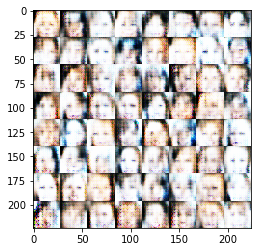

Epoch 0/1... Step: 3110... Discriminator Loss: 0.7698... Generator Loss: 1.9841
Epoch 0/1... Step: 3120... Discriminator Loss: 0.7391... Generator Loss: 3.3518
Epoch 0/1... Step: 3130... Discriminator Loss: 1.5316... Generator Loss: 0.8811
Epoch 0/1... Step: 3140... Discriminator Loss: 0.5561... Generator Loss: 3.2459
Epoch 0/1... Step: 3150... Discriminator Loss: 1.0365... Generator Loss: 1.8494
Epoch 0/1... Step: 3160... Discriminator Loss: 0.5749... Generator Loss: 2.6032


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。